In [1]:
# import libraries
from cil.optimisation.algorithms import PDHG
from cil.optimisation.functions import L2NormSquared, MixedL21Norm, BlockFunction, IndicatorBox, TotalVariation
from cil.optimisation.operators import BlockOperator, GradientOperator
from cil.framework import ImageGeometry, AcquisitionGeometry, AcquisitionData, BlockDataContainer
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins.ccpi_regularisation.functions import FGP_TV  
from cil.utilities.display import show2D

import numpy as np
import os, sys

import tomophantom
from tomophantom import TomoP2D

import matplotlib.pyplot as plt

In [2]:
# Load a tomophantom image 
model = 8 # select a model number from the library
N = 256 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom2D_np = TomoP2D.Model(model, N, path_library2D)    
ig = ImageGeometry(voxel_num_x=N, voxel_num_y=N, voxel_size_x = 0.5, voxel_size_y = 0.5)

phantom2D = ig.allocate()
phantom2D.fill(phantom2D_np)

In [3]:
# Create Acquisition Geometry
detectors =  int(np.sqrt(2)*N)
angles = np.linspace(0, np.pi, 90, dtype=np.float32)

ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles,angle_unit="radian")\
                        .set_panel(detectors, pixel_size=0.5)

In [4]:
device = "gpu"

In [5]:
# Create Projection Operator
A = ProjectionOperator(ig, ag, device )

In [6]:
# Create projection data and corrupt with noise
np.random.seed(10)

data = A.direct(phantom2D)
noisy_data = ag.allocate()
noisy_data.fill(data.as_array() + np.random.normal(0, 0.5, ag.shape))

In [7]:
# Regularisation parameter
alpha = 2

In [8]:
# Setup and run PDHG (explicit) algorithm
f = BlockFunction(0.5 * L2NormSquared(b=noisy_data), alpha * MixedL21Norm())
g = IndicatorBox(lower=0.0)

Grad = GradientOperator(ig)
K = BlockOperator(A, Grad)

normK = K.norm()
sigma = 1.
tau = 1./(sigma*normK**2)

pdhg_explicit = PDHG(f=f, g=g, operator=K, sigma=sigma, tau=tau,
           max_iteration=2000, update_objective_interval=500)
pdhg_explicit.run(verbose=2)

Initialised GradientOperator with C backend running with  20  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       2000         0.000    1.98606e+06  -0.00000e+00    1.98606e+06


/opt/anaconda3/envs/cil21_ep/lib/python3.8/site-packages/cil/framework/framework.py:2185: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      500       2000         0.017    6.01431e+03   4.20907e+03    1.80524e+03
     1000       2000         0.017    5.96641e+03   5.40226e+03    5.64148e+02
     1500       2000         0.017    5.95377e+03   5.74353e+03    2.10240e+02
     2000       2000         0.017    5.94949e+03   5.86207e+03    8.74197e+01
----------------------------------------------------------------------------
     2000       2000         0.017    5.94949e+03   5.86207e+03    8.74197e+01
Stop criterion has been reached.



In [9]:
# Setup and run PDHG (implicit) algorithm, using TotalVariation function (cpu)
normK = A.norm()

f1 = 0.5 * L2NormSquared(b=noisy_data)
g1 = alpha*TotalVariation(max_iteration=100,lower=0.) 
K1 = A
normK = A.norm()

sigma = 1./normK
tau = 1./normK

pdhg_implicit_cpu = PDHG(f=f1, g=g1, operator=K1, sigma=sigma, tau=tau,
           max_iteration=1000, update_objective_interval=200)
pdhg_implicit_cpu.run(verbose=2)

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
Initialised GradientOperator with C backend running with  20  threads
        0       1000         0.000    1.98606e+06  -0.00000e+00    1.98606e+06
      200       1000         0.190    5.95029e+03   5.94127e+03    9.02026e+00
      400       1000         0.194    5.94884e+03   5.96033e+03   -1.14851e+01
      600       1000         0.194    5.94892e+03   5.96046e+03   -1.15413e+01
      800       1000         0.195    5.94895e+03   5.96046e+03   -1.15085e+01
     1000       1000         0.194    5.94893e+03   5.96046e+03   -1.15283e+01
----------------------------------------------------------------------------
     1000       1000         0.194    5.94893e+03   5.96046e+03   -1.15283e+01
Stop criterion has been reached.



In [10]:
# Setup and run PDHG (implicit) algorithm, using FGP_TV function from the CCPiRegularisation toolkit (gpu)
g2 = (alpha/ig.voxel_size_x)*FGP_TV(device="gpu", max_iteration=100)

pdhg_implicit_gpu = PDHG(f=f1, g=g2, operator=K1, sigma=sigma, tau=tau,
           max_iteration=500, update_objective_interval=100)
pdhg_implicit_gpu.run(verbose=2)


PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        500         0.000    1.98606e+06  -0.00000e+00    1.98606e+06
      100        500         0.044    6.02171e+03   5.86264e+03    1.59073e+02
      200        500         0.042    5.95049e+03   5.94111e+03    9.38525e+00
      300        500         0.042    5.94876e+03   5.95930e+03   -1.05388e+01
      400        500         0.042    5.94880e+03   5.96030e+03   -1.14978e+01
      500        500         0.042    5.94878e+03   5.96042e+03   -1.16431e+01
----------------------------------------------------------------------------
      500        500         0.042    5.94878e+03   5.96042e+03   -1.16431e+01
Stop criterion has been reached.



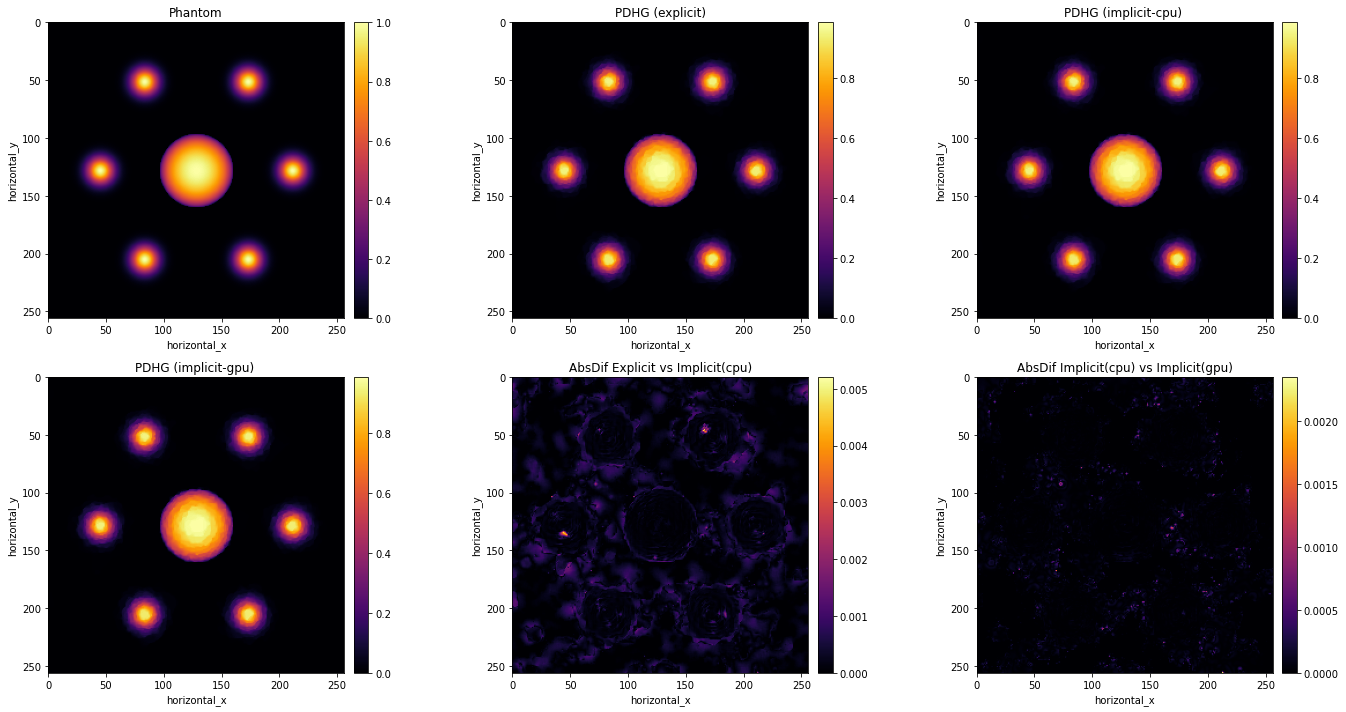

In [11]:
show2D([phantom2D, pdhg_explicit.solution, pdhg_implicit_cpu.solution,  
        pdhg_implicit_gpu.solution, (pdhg_explicit.solution-pdhg_implicit_cpu.solution).abs(),
       (pdhg_implicit_cpu.solution-pdhg_implicit_gpu.solution).abs()],num_cols=3, size=(20,10),
          title=["Phantom", "PDHG (explicit)", "PDHG (implicit-cpu) ", 
                 "PDHG (implicit-gpu) ", "AbsDif Explicit vs Implicit(cpu)", "AbsDif Implicit(cpu) vs Implicit(gpu)"],
         origin = "upper", cmap="inferno")

In [12]:
# from cil.optimisation.functions import Function
# import numpy
# from numbers import Number

# class new_TotalVariation(Function):
    
#     r'''Fast Gradient Projection algorithm for Total Variation(TV) Denoising (ROF problem)
    
#     .. math::  \min_{x} \alpha TV(x) + \frac{1}{2}||x-b||^{2}_{2}
                
#     Parameters:
      
#       :param max_iteration: max iterations of FGP algorithm
#       :type max_iteration: int, default 100
#       :param tolerance: Stopping criterion
#       :type tolerance: float, default `None` 
#       :param correlation: Correlation between `Space` and/or `SpaceChannels` for the GradientOperator
#       :type correlation: str, default 'Space'
#       :param backend: Backend to compute finite differences for the GradientOperator
#       :type backend: str, default 'c'
#       :param lower:lower bound for the orthogonal projection onto the convex set C
#       :type lower: Number, default `-numpy.inf`
#       :param upper: upper bound for the orthogonal projection onto the convex set C
#       :type upper: Number, default `+numpy.inf`
#       :param info: force a print to screen stating the stop
#       :type info: bool, default `False`
#     Reference:
      
#         A. Beck and M. Teboulle, "Fast Gradient-Based Algorithms for Constrained Total Variation 
#         Image Denoising and Deblurring Problems," in IEEE Transactions on Image Processing,
#         vol. 18, no. 11, pp. 2419-2434, Nov. 2009, 
#         doi: 10.1109/TIP.2009.2028250.
        
#     '''    
    
    
#     def __init__(self,
#                  max_iteration=100, 
#                  tolerance = None, 
#                  correlation = "Space",
#                  backend = "c",
#                  lower = -numpy.inf, 
#                  upper = numpy.inf,
#                  info = False):
        

#         super(new_TotalVariation, self).__init__(L = None)
#         # Regularising parameter = alpha
#         self.regularisation_parameter = 1.
        
#         # Iterations for FGP_TV
#         self.iterations = max_iteration
        
#         # Tolerance for FGP_TV
#         self.tolerance = tolerance
        
#         # Define (ISOTROPIC) Total variation penalty ( Note it is without the regularisation paremeter)
#         # TODO add anisotropic???
#         self.TV = MixedL21Norm() 
                
#         # correlation space or spacechannels
#         self.correlation = correlation
#         self.backend = backend        
        
#         # Define orthogonal projection onto the convex set C
#         self.lower = lower
#         self.upper = upper
#         self.tmp_proj_C = IndicatorBox(lower, upper).proximal
                        
# #         Setup GradientOperator as None. This is to avoid domain argument in the __init__     

#         self._gradient = None
#         self._domain = None

#         self.pptmp = None
#         self.pptmp1 = None
                     
#         # Print stopping information (iterations and tolerance error) of FGP_TV  
#         self.info = info
#     @property
#     def regularisation_parameter(self):
#         return self._regularisation_parameter

#     @regularisation_parameter.setter
#     def regularisation_parameter(self, value):
#         if not isinstance(value, Number):
#             raise TypeError("regularisation_parameter: expectec a number, got {}".format(type(value)))
#         self._regularisation_parameter = value

#     def __call__(self, x):
        
#         r''' Returns the value of the \alpha * TV(x)'''
#         self._domain = x.geometry
#         # evaluate objective function of TV gradient
#         return self.regularisation_parameter * self.TV(self.gradient.direct(x))
    
    
#     def projection_C(self, x, out=None):   
                     
#         r''' Returns orthogonal projection onto the convex set C'''

#         self._domain = x.geometry
#         return self.tmp_proj_C(x, tau = None, out = out)
                        
#     def projection_P(self, x, out=None):
                       
#         r''' Returns the projection P onto \|\cdot\|_{\infty} '''  
#         self._domain = x.geometry
        
#         # preallocated in proximal
#         tmp = self.pptmp
#         tmp1 = self.pptmp1
#         tmp1 *= 0
        

#         for i,el in enumerate(x.containers):
#             el.multiply(el, out=tmp)
#             tmp1.add(tmp, out=tmp1)
#         tmp1.sqrt(out=tmp1)
#         tmp1.maximum(1.0, out=tmp1)
#         if out is None:
#             return x.divide(tmp1)
#         else:
#             x.divide(tmp1, out=out)
    
    
#     def proximal(self, x, tau, out = None):
        
#         ''' Returns the solution of the FGP_TV algorithm '''         
#         self._domain = x.geometry
        
#         # initialise
#         t = 1        
#         tmp_p = self.gradient.range_geometry().allocate(0)  
#         self.tmp_q = tmp_p.copy()
#         tmp_x = self.gradient.domain_geometry().allocate(None)     
#         p1 = self.gradient.range_geometry().allocate(None)
        

#         should_break = False
#         for k in range(self.iterations):
                                                                                   
#             t0 = t
#             self.gradient.adjoint(self.tmp_q, out = tmp_x)
            
#             # axpby now works for matrices
#             tmp_x.axpby(-self.regularisation_parameter*tau, 1.0, x, out=tmp_x)
#             self.projection_C(tmp_x, out = tmp_x)                       

#             self.gradient.direct(tmp_x, out=p1)
#             if isinstance (tau, (Number, np.float32, np.float64)):
#                 p1 *= self.L/(self.regularisation_parameter * tau)
#             else:
#                 p1 *= self.L/self.regularisation_parameter
#                 p1 /= tau

#             if self.tolerance is not None:
                
#                 if k%5==0:
#                     error = p1.norm()
#                     p1 += self.tmp_q
#                     error /= p1.norm()
#                     if error<=self.tolerance:                           
#                         should_break = True
#                 else:
#                     p1 += self.tmp_q
#             else:
#                 p1 += self.tmp_q
#             if k == 0:
#                 # preallocate for projection_P
#                 self.pptmp = p1.get_item(0) * 0
#                 self.pptmp1 = self.pptmp.copy()

#             self.projection_P(p1, out=p1)
                        

#             t = (1 + numpy.sqrt(1 + 4 * t0 ** 2)) / 2
            
#             #tmp_q.fill(p1 + (t0 - 1) / t * (p1 - tmp_p))
#             p1.subtract(tmp_p, out=self.tmp_q)
#             self.tmp_q *= (t0-1)/t
#             self.tmp_q += p1
            
#             tmp_p.fill(p1)

#             if should_break:
#                 break
        
#         #clear preallocated projection_P arrays
#         self.pptmp = None
#         self.pptmp1 = None
        
#         # Print stopping information (iterations and tolerance error) of FGP_TV     
#         if self.info:
#             if self.tolerance is not None:
#                 print("Stop at {} iterations with tolerance {} .".format(k, error))
#             else:
#                 print("Stop at {} iterations.".format(k))                
            
#         if out is None:                        
#             self.gradient.adjoint(self.tmp_q, out=tmp_x)
#             tmp_x *= tau
#             tmp_x *= self.regularisation_parameter 
#             x.subtract(tmp_x, out=tmp_x)
#             return self.projection_C(tmp_x), self.tmp_q
#         else:          
#             self.gradient.adjoint(self.tmp_q, out = out)
#             out*=tau
#             out*=self.regularisation_parameter
#             x.subtract(out, out=out)
#             self.projection_C(out, out=out)
#             return out, self.tmp_q
    
#     def convex_conjugate(self,x):     
# #         tmp = np.maximum(self.proximal(x, tau)[1].pnorm(2).max()-alpha,0)
# #         tmp = np.maximum( self.proximal(x, tau)[1]).pnorm(2).max()-1, 0)
# #         tmp = self.gradient.adjoint(self.proximal(x, tau)[1]).max()
#         print(self.proximal(x, tau)[1].pnorm(2).max()-1)
# #         print(self.gradient.adjoint(self.proximal(x, tau)[1]).max()-1)
# #         print(self.gradient.adjoint(self.proximal(x, tau)[1]).max()-1)
#         return self.proximal(x, tau)[1].pnorm(2).max().sum()
# #         print(self.proximal(x, tau)[1].sum())
# #         return self.gradient.adjoint(self.proximal(x, tau)[1]).abs().sum()
# #         return self.proximal(x, tau)[1].pnorm(2).sum()
#     @property
#     def L(self):
#         if self._L is None:
#             self.calculate_Lipschitz()
#         return self._L
#     @L.setter
#     def L(self, value):
#         warnings.warn("You should set the Lipschitz constant with calculate_Lipschitz().")
#         if isinstance(value, (Number,)) and value >= 0:
#             self._L = value
#         else:
#             raise TypeError('The Lipschitz constant is a real positive number')

#     def calculate_Lipschitz(self):
#         # Compute the Lipschitz parameter from the operator if possible
# #         Leave it initialised to None otherwise
#         self._L = (1./self.gradient.norm())**2  
    
#     @property
#     def gradient(self):
#         '''creates a gradient operator if not instantiated yet
#         There is no check that the variable _domain is changed after instantiation (should not be the case)'''
#         if self._gradient is None:
#             if self._domain is not None:
#                 self._gradient = GradientOperator(self._domain, correlation = self.correlation, backend = self.backend)
#         return self._gradient
#     def __rmul__(self, scalar):
#         if not isinstance (scalar, Number):
#             raise TypeError("scalar: Expectec a number, got {}".format(type(scalar)))
#         self.regularisation_parameter = scalar
#         return self
